# Edge Detection Algorithms

This jupyter notebook aims to present several edge detection algorithms, show their implementation in python and make a comparison between them.

Currently implemented algorithms include Sobel, Prewitt, Roberts, and Canny edge detectors.

In [1]:
from scipy.signal import convolve2d
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.setrecursionlimit(25000000)
%matplotlib inline

EPS = 0.0001

### Gaussian filter
Gaussian filter is responsible for smoothing out an image removing abrupt changes in neighbour pixels.

As all gradient based algorithms are very sensitive on noise and can have a huge performance change due to fluctuations and anomalies in images, it's a reasonable decision to apply gaussian filter on images before giving them to any edge detector. We could use any smoothing filter but Gaussian is shown to work good in practice.

Usually, for edge detection, people choose 5x5 gaussian filter with standard deviation=1.4, so that's why the default parameters of our function are `kernel_size=(5,5)`, `standard_deviation=1.4`

In [2]:
def gaussian_filter(kernel_size=(5,5), standard_deviation=1.4, normalize=True):
    """
    :returns 2D Gaussian mask of shape kernel_size
    """
    res = np.zeros(shape=kernel_size)
    centerI = ( kernel_size[0] - 1 ) / 2
    centerJ = ( kernel_size[1] - 1 ) / 2
    for i in range(kernel_size[0]):
        for j in range(kernel_size[1]):
            res[i][j] = np.exp( -( (i - centerI)**2. + (j - centerJ)**2. ) / ( 2. * standard_deviation**2. )) \
                        / ( 2. * np.pi * standard_deviation**2. )
    
    if normalize:
        res /= np.sum(res)
    return res

def smooth_gaussian(input_image):
    """Helper function for applying gaussian filter on an input image"""
    return convolve2d(input_image, gaussian_filter(), mode='same')

In [3]:
def apply_thresholding(input_image, threshold=70, high_value=255, low_value=0):
    result = np.copy(input_image)
    high_indices = result[:,:] > threshold
    low_indices = result[:,:] <= threshold
    result[high_indices] = high_value
    result[low_indices] = low_value
    return result

In [4]:
class EdgeDetector(object):
    """
    Base class for all edge detecting classes
    Any edge detector should implement an abstract function run_algorithm(input_image)
    """
    def __init__(self, smooth_image=None, apply_thresholding=None):
        self.smooth_image = smooth_image
        self.apply_thresholding = apply_thresholding
    
    def normalize_image(self, image):
        """ Maps image from any range to [0;255] """
        image -= image.min()
        if image.max() != 0:
            image *= 255./image.max()
        return image
    
    def detect_edges(self, input_image):
        """
        Applies smoothing if it's not None
        runs algorithm defined by a subclass
        Applies thesholding if it's not None
        :returns result
        """
        if self.smooth_image is not None:
            input_image = self.smooth_image(input_image)
        
        result = self.run_algorithm(input_image)
        result = self.normalize_image(result)
        
        if self.apply_thresholding is not None:
            result = self.apply_thresholding(result)
        return result
    
    def run_algorithm(self, input_image):
        raise NotImplementedError('Please implement this method')

## First degree derivative based algorithms
### Operator based Edge detectors
As Sobel's, Prewitt's or  Robert's algortihms are based on applying a convolutional filter on the input image, they all share the same logic of processing the input. The only difference is the kernel matrix that is applied to an input image.

So, lets create a base class for this kind of edge detectors `OperatorEdgeDetector`

In [8]:
class OperatorEdgeDetector(EdgeDetector):
    def __init__(self, filterX, filterY, smooth_image=smooth_gaussian, thresholding=apply_thresholding):
        """
        :param filterX filter-matrix (kernel) to compute gradient on X direction
        :param filterY filter-matrix (kernel) to compute gradient on Y direction
        :param smooth_image a function that will smooth the image before doing any detection
                            the default is gaussian, but it can be any function (set to None if no filtering is needed)
        """
        super().__init__(smooth_image=smooth_image, apply_thresholding=thresholding)
        self.filterX = filterX
        self.filterY = filterY
        
    def get_gradients(self, input_image):
        """
        :returns gradients in X and Y directions
        """
        gradX = convolve2d(input_image, self.filterX, mode='same') # Convolve input image with filter-matrix in X direction
        gradY = convolve2d(input_image, self.filterY, mode='same') # Convolve input image with filter-matrix in Y direction
        return gradX, gradY
    
    def run_algorithm(self, input_image):
        """
        Computes gradient in X and Y directions (gradX and gradY respectively)
        And gets the result by combining this gradients with sqrt( gradX^2 + gradY^2 )
        :returns 2D matrix of edges 
            closer to 255 => edges are more visible
            closer to 0 => no edges there
        """
        
        gradX, gradY = self.get_gradients(input_image)
        result = np.sqrt( np.power(gradX, 2) + np.power(gradY, 2) )
        return result

### Sobel
Sobel's edge detector is a simple convolutional filter with kernel matrix

In X and Y directions respectively
```
-1 0 1             -1 -2 -1
-2 0 2              0 0 0
-1 0 1              1 2 1```

In [9]:
class SobelEdgeDetector(OperatorEdgeDetector):
    def __init__(self, smooth_image=smooth_gaussian, thresholding=apply_thresholding):
        filterX = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)
        filterY = np.array([[-1, -2, -1],
                            [0, 0, 0],
                            [1, 2, 1]], dtype=np.float32)
        super().__init__(filterX=filterX, filterY=filterY, smooth_image=smooth_image, thresholding=thresholding)

### Prewitt
Prewitt's edge detector is also a simple convolutional filter with kernel matrix

In X and Y directions respectively
```
-1 0 1             -1 -1 -1
-1 0 1              0 0 0
-1 0 1              1 1 1```

In [10]:
class PrewittEdgeDetector(OperatorEdgeDetector):
    def __init__(self, smooth_image=smooth_gaussian, thresholding=apply_thresholding):
        filterX = np.array([[-1, 0, 1],
                            [-1, 0, 1],
                            [-1, 0, 1]], dtype=np.float32)
        filterY = np.array([[-1, -1, -1],
                            [0, 0, 0],
                            [1, 1, 1]], dtype=np.float32)
        super().__init__(filterX=filterX, filterY=filterY, smooth_image=smooth_image, thresholding=thresholding)

### Robert
Robert's edge detector is also a simple convolutional filter with kernel matrix

In X and Y directions respectively
```
-1 0             0 -1
0 1              1 0```

In [11]:
class RobertsEdgeDetector(OperatorEdgeDetector):
    def __init__(self, smooth_image=smooth_gaussian, thresholding=apply_thresholding):
        filterX = np.array([[-1, 0],
                            [0, 1]], dtype=np.float32)
        filterY = np.array([[0, -1],
                            [1, 0]], dtype=np.float32)
        super().__init__(filterX=filterX, filterY=filterY, smooth_image=smooth_image, thresholding=thresholding)

### Canny
Canny edge detection algorithm is an extention of any algorithm listed above. It refines the edges found with Sobel/Prewitt/or any other gradient based edge detector.

Algorithm:
0. Apply `image smoothing` (Gaussian filter) and `compute gradients` in X and Y directions
1. Apply `thresholding` to choose those edges that have enough intensity to consider them as a real edge and not a noise
2. Apply `Nonmaxima Suppression` during which it compares every pixel with its neighbours along the gradient direction to make sure that it's maximum among them. If not, the pixel is set to non-edge (black).
3. Traverse (DFS - depth first search) all edges and leave only those weak edges that are connected to a strong edges and remove all other ones.

In [12]:
def double_thresholding(input_image, threshold_hight=60, threshold_low=20, high_value=255, low_value=0):
    result = np.copy(input_image)
    high_indices = result[:,:] > threshold_hight
    low_indices = result[:,:] < threshold_low
    result[high_indices] = high_value
    result[low_indices] = low_value
    return result

In [13]:
class CannyEdgeDetector(EdgeDetector):
    def __init__(self, 
                 smooth_image=smooth_gaussian, 
                 gradient_calculator=SobelEdgeDetector(), 
                 thresholding=double_thresholding):
        super().__init__(smooth_image, apply_thresholding=thresholding)
        self.gradient_calculator = gradient_calculator

    def suppress_non_maxima(self, gradient, angle):
        
        h = gradient.shape[0]
        w = gradient.shape[1]
        assert(h == angle.shape[0] and w == angle.shape[1])
        result = np.copy(gradient)

        def update_result(i, j, neighbours):
            # if gradient[i][j] is not the greatest among its neighbours => set the result to 0
            if any([ gradient[i][j] < gradient[item_i][item_j] for (item_i, item_j) in neighbours]):
                result[i][j] = 0
        
        def normalize_angle(val):
            val = val if val > 0 else val + 2*np.pi
            val = min([np.pi*0/4,  np.pi*1/4, np.pi*2/4, np.pi*3/4,
                                   np.pi*4/4, np.pi*5/4, np.pi*6/4, np.pi*7/4, 
                                   np.pi*8/4], key=lambda x: abs(x-val))
            if val == np.pi*2 or val == np.pi: val = 0
            if val > np.pi: val -= np.pi
            return val
        
        # Normalize angle to be one of the [0, pi/4, pi/2, 3pi/4]
        for i in range(angle.shape[0]):
            for j in range(angle.shape[1]):
                angle[i][j] = normalize_angle( angle[i][j] )
        
        for i in range(1, h-1):
            for j in range(1, w-1):
                if abs(angle[i][j] - 0) < EPS:          update_result(i, j, [(i, j-1), (i, j+1)])
                if abs(angle[i][j] - np.pi/4) < EPS:    update_result(i, j, [(i-1, j+1), (i+1, j-1)])
                if abs(angle[i][j] - np.pi/2) < EPS:    update_result(i, j, [(i-1, j), (i+1, j)])
                if abs(angle[i][j] - np.pi*3/4) < EPS:  update_result(i, j, [(i, j+1), (i+1, j+1)])
        return result
    
    
    def traverse(self, i, j, used, result):
        if i < 0 or i >= used.shape[0]:              return
        if j < 0 or j >= used.shape[1]:              return
        if result[i][j] <= 0.001 or used[i][j] == True:  return
        used[i][j] = True
        result[i][j] = 255
        for I in range(i-1, i+2):
            for J in range(j-1, j+2):
                self.traverse(I, J, used, result)        
        
    
    def detect_edges(self, input_image):
        # 1. Apply image smoothing if provided
        if self.smooth_image is not None:
            input_image = self.smooth_image(input_image)
        
        # 2. Compute gradients of the image
        gradient, angle = self.run_algorithm(input_image)
        gradient = self.normalize_image(gradient)
        
        # 3. Apply double-trhresholding
        gradient = self.apply_thresholding(gradient)
        
        # 4. Apply Nonmaxima Suppression (compare every pixel alonge the gradient, take maximal) => thin down edges
        result = self.suppress_non_maxima(gradient, angle)
        
        # 5. Traverse along the weak edges and take only those that are connected to strong ones
        used = np.zeros(shape=result.shape, dtype=np.bool)
        for i in range(0, result.shape[0]):
            for j in range(0, result.shape[1]):
                if result[i][j] == 255:
                    self.traverse(i, j, used, result)
        
        # Take only those edges that were connected to strong ones in previous step
        idx = result[:,:] != 255
        result[idx] = 0
        return result
        
        
    def run_algorithm(self, input_image):
        gradX, gradY = self.gradient_calculator.get_gradients(input_image)
        gradient = np.sqrt( np.power(gradX, 2), np.power(gradY, 2) )
        result = np.copy(gradient)
        angle = np.arctan2(gradY, gradX)
        
        return result, angle

## Second degree derivative based algorithms
### Laplacian

Reference: http://fourier.eng.hmc.edu/e161/lectures/gradient/node8.html

To find edges with second order derivative we need to find all intersections with 0 of the function. In this case our function is considered to be each `3x3` sum-matrix of the input image colvolved by the `laplacian filter`.

If the center of `3x3` sub-matrix is greater than 0 and there is an element in that matrix that is smaller than 0 => there was a 0 intersection. Also if the center is smaller than 0 and there is an element that is larger than 0 => there also was an intersection with 0. To have a valid edge we also need to take into account that minimum and maximum elements of the `3x3` matrix are different enough (i.e. max - min > threshold)

If all the conditions above are satisfied then the center of `3x3` matrix is considered part of an edge

In [14]:
class LaplacianEdgeDetector(EdgeDetector):
    def __init__(self, laplacian_filter=None, smooth_image=smooth_gaussian):
        """
        :param laplacian_filter 2D np.array of values representing laplacian filter
        """
        super().__init__(smooth_image=smooth_image, apply_thresholding=None)
        if laplacian_filter is None:
            self.laplacian_filter = np.array([[0, 0, 1, 0, 0],
                                              [0, 1, 2, 1, 0],
                                              [1, 2, -16, 2, 1],
                                              [0, 1, 2, 1, 0],
                                              [0, 0, 1, 0, 0]], dtype=np.float32)
        else:
            self.laplacian_filter = laplacian_filter
        
    def run_algorithm(self, input_image, threshold=170):
        f = convolve2d(input_image, self.laplacian_filter, mode='same')
        result = np.zeros(shape=f.shape, dtype=np.float32)

        h = result.shape[0] # Height of the result
        w = result.shape[1] # Width of the result
        for i in range(1, h-1):
            for j in range(1, w-1):
                patch = f[i-1:i+2, j-1:j+2]            # Take the neighbour square of edge-size 3
                maxP = patch.max()                     # Compute maximum of that square
                minP = patch.min()                     # Compute minimum of that square
                if f[i][j] > 0:  zeroCross = minP < 0  # If there is an element lower than 0 and f[i][j] > 0
                else:            zeroCross = maxP > 0  # If there is an element greater than 0 and f[i][j] < 0
                    
                # If the difference between min and max elements is not too low and there is a zeroCross => it's an edge
                if maxP - minP > threshold and zeroCross:
                    result[i][j] = 255
        return result

In [35]:
class LaplacianConvolution(EdgeDetector):
    def __init__(self, laplacian_filter=None, smooth_image=smooth_gaussian):
        super().__init__(smooth_image=smooth_image, apply_thresholding=None)
        self.laplacian_filter = np.array([[0, 1, 0],
                                          [1, -4, 1],
                                          [0, 1, 0]], dtype=np.float32)
 
    def detect_edges(self, input_image):
        return convolve2d(input_image, self.laplacian_filter, mode='same')

## Comparison of the algorithms

In [15]:
def print_detections(input_image, detectors):
    
    def show(ax, image, label):
        ax.imshow(image, cmap='gray')
        ax.set_title(label)
        ax.axis('off')
        
    f, axis = plt.subplots(1, len(detectors)+1)
    f.set_figheight(15)
    f.set_figwidth(15)
    
    show(axis[0], input_image, 'Original')    
    for i, (edge_detector, label) in enumerate(detectors):
        out = edge_detector.detect_edges(input_image)
        show(axis[i+1], out, label)

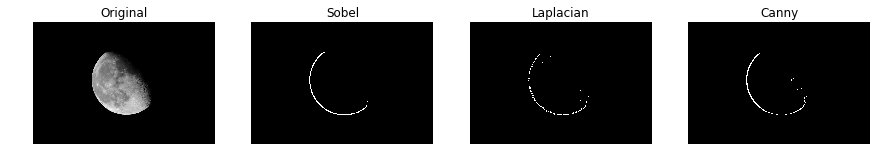

In [16]:
img = misc.imread('./moon.jpg', mode='L')
sobel = SobelEdgeDetector()
roberts = RobertsEdgeDetector()
prewitt = PrewittEdgeDetector()
laplace = LaplacianEdgeDetector()
canny = CannyEdgeDetector()

# algorithms = [(sobel, 'Sobel'), (prewitt, 'Prewitt'), (roberts, 'Roberts'), (laplace, 'Laplacian'), (canny, 'Canny')]
algorithms = [(sobel, 'Sobel'), (laplace, 'Laplacian'), (canny, 'Canny')]
print_detections(img, algorithms)

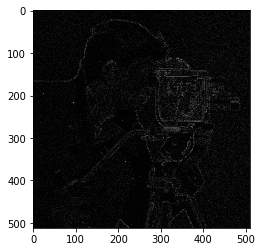

In [42]:
img = misc.imread('./cman.jpg', mode='L')
detector = LaplacianConvolution()
res = detector.detect_edges(img)
plt.imshow(abs(res), cmap='gray')